In [1]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
from datasets import makeTesting_adv, GRF_pos
from datasets import parallel_solver, advection_solver
from utils.func import dirichlet, periodic
from utils.PDETriple import PDETripleCartesianProd
from utils.pdes import advection_equation

date = time.strftime("%Y%m%d-%H-%M-%S", time.localtime())
# dde.config.set_random_seed(2023)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
total_training_vx = 300
ls = 0.1
testing_path = f"datasets/ADV_100_{ls:.2f}_101_101.npz"

start_num = 300
check_num = 100
select_num = 20
solver_worker = 6

lr_start = 5e-3
lr_middle = 1e-3
lr_end = 1e-3

iter_start = 10000
iter_middle = 10000
iter_end = 60000

batch_start = lambda n: 2
batch_middle = lambda n: 2
batch_end = lambda n: n

decay_start = None
decay_middle = None
decay_end = None

if False:
    makeTesting_adv(length_scale = ls)

In [3]:
space = GRF_pos(1.0, length_scale = ls, N= 1000, interp="cubic")

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
vxs = space.eval_batch(space.random(start_num), np.linspace(0, 1, 101)[:, None])
# vxs = vxs - vxs.min(axis = 0, keepdims = True) + 0.5
uxts = parallel_solver(advection_solver, vxs, num_workers = solver_worker)
grid = uxts[0][0].reshape(101 * 101, -1)
uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

(300, 1000)
...........................................

In [ ]:
train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load(testing_path)
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs.shape, test_grid.shape, test_uxts.shape)

(20, 101) (10201, 2) (20, 10201)
(100, 101) (10201, 2) (100, 10201)


In [ ]:
data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 100, 100],
    [2, 100, 100, 100],
    "gelu",
    "Glorot normal",
)

# net.apply_output_transform(dirichlet)

# pre-train
model = dde.Model(data, net)
model.compile("adam", 
              lr= lr_start, 
              loss= ["mse"], 
              metrics = ["mean l2 relative error"], 
              decay = decay_start)

Compiling model...
'compile' took 0.000347 s



Training model...

Step      Train loss    Test loss     Test metric   
0         [2.17e-01]    [2.33e-01]    [7.68e-01]    
1000      [1.31e-02]    [2.04e-02]    [2.25e-01]    
2000      [9.10e-03]    [1.78e-02]    [2.11e-01]    
3000      [9.78e-03]    [1.89e-02]    [2.16e-01]    
4000      [9.27e-03]    [1.67e-02]    [2.03e-01]    
5000      [8.31e-03]    [1.65e-02]    [2.03e-01]    
6000      [2.91e-02]    [2.31e-02]    [2.38e-01]    
7000      [1.17e-02]    [1.80e-02]    [2.12e-01]    
8000      [9.47e-03]    [1.89e-02]    [2.17e-01]    
9000      [1.06e-02]    [2.02e-02]    [2.26e-01]    
10000     [1.17e-02]    [1.76e-02]    [2.10e-01]    

Best model at step 5000:
  train loss: 8.31e-03
  test loss: 1.65e-02
  test metric: [2.03e-01]

'train' took 74.386979 s



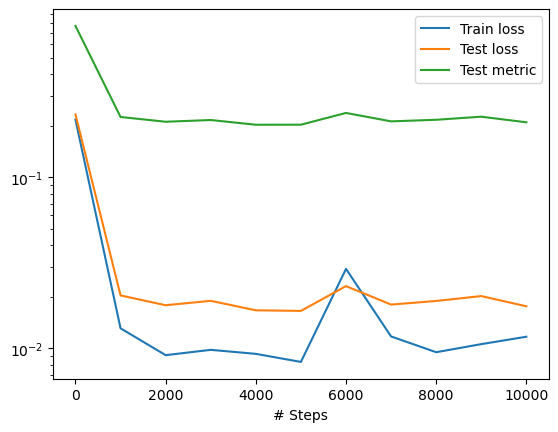

In [ ]:
losshistory, train_state = model.train(iterations = iter_start, batch_size = batch_start(len(train_vxs)))
dde.utils.plot_loss_history(losshistory)

losshistory.to_pandas().to_csv(f"results/adv_{date}_rasg.csv", index=False)

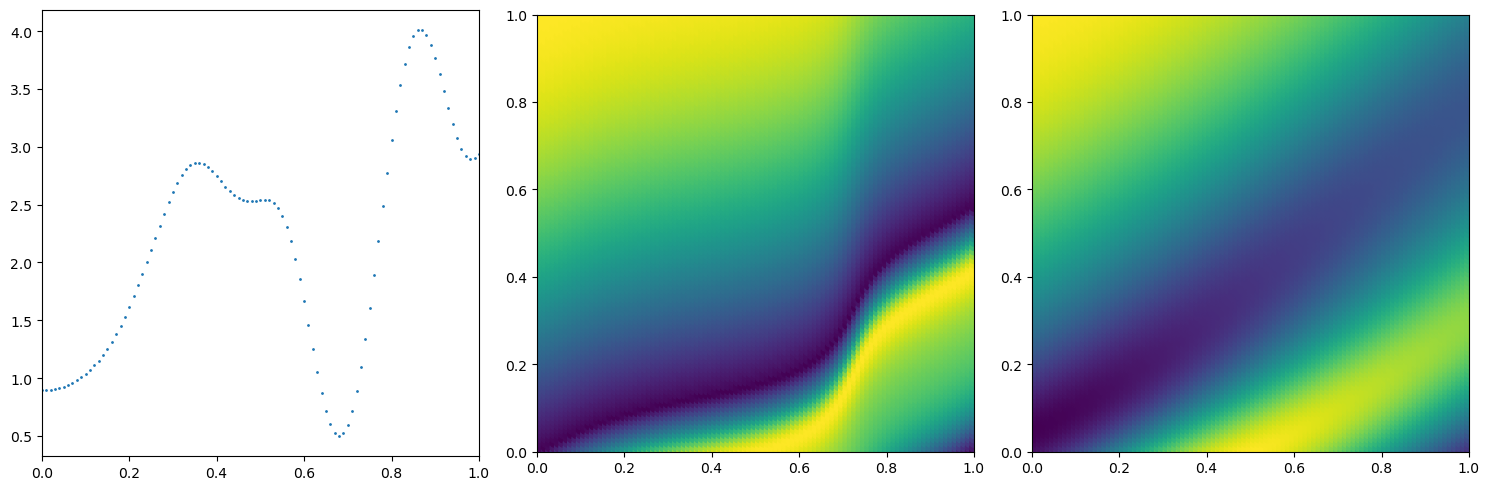

In [ ]:
# plot-data
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5))

v = test_vxs[1]
x = np.linspace(0,1,v.shape[0])

ax1.set_xlim(0,1)
ax1.scatter(x, v, s=1)

ut = test_uxts[3]
xt = test_grid

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_aspect('equal')
ax2.scatter(xt[...,0], xt[...,1], c=ut)

out = model.predict((test_vxs[(0,),...], xt))

ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_aspect('equal')
ax3.scatter(xt[...,0], xt[...,1], c=out)

plt.tight_layout()
plt.show()

(100, 1000)
3.2474813 0.51660854
40
Compiling model...
'compile' took 0.000293 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.56e-02]    [1.76e-02]    [2.10e-01]    
1000      [6.42e-03]    [1.66e-02]    [1.98e-01]    
2000      [1.00e-02]    [1.56e-02]    [1.90e-01]    
3000      [8.85e-03]    [1.79e-02]    [1.94e-01]    
4000      [1.26e-02]    [2.27e-02]    [2.13e-01]    
5000      [6.64e-03]    [2.60e-02]    [2.12e-01]    
6000      [4.80e-03]    [2.38e-02]    [2.01e-01]    
7000      [3.80e-03]    [1.20e-02]    [1.71e-01]    
8000      [1.03e-02]    [1.42e-02]    [1.84e-01]    
9000      [5.10e-03]    [1.81e-02]    [1.78e-01]    
10000     [4.61e-03]    [1.82e-02]    [1.78e-01]    

Best model at step 7000:
  train loss: 3.80e-03
  test loss: 1.20e-02
  test metric: [1.71e-01]

'train' took 78.850157 s



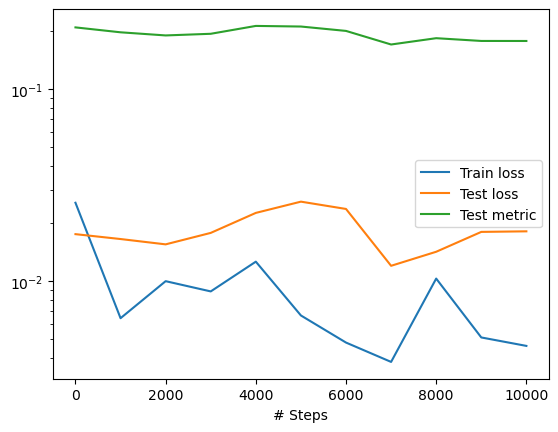

(100, 1000)
3.330169 0.43533093
60
Compiling model...
'compile' took 0.000220 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [7.14e-03]    [1.82e-02]    [1.78e-01]    
1000      [5.10e-03]    [1.07e-02]    [1.59e-01]    
2000      [4.09e-03]    [1.00e-02]    [1.56e-01]    
3000      [4.16e-03]    [1.09e-02]    [1.62e-01]    
4000      [8.51e-03]    [1.13e-02]    [1.66e-01]    
5000      [1.06e-02]    [1.60e-02]    [1.88e-01]    
6000      [6.06e-03]    [1.32e-02]    [1.81e-01]    
7000      [8.62e-03]    [1.15e-02]    [1.67e-01]    
8000      [5.36e-03]    [1.26e-02]    [1.75e-01]    
9000      [7.11e-03]    [1.07e-02]    [1.62e-01]    
10000     [1.01e-02]    [1.11e-02]    [1.65e-01]    

Best model at step 2000:
  train loss: 4.09e-03
  test loss: 1.00e-02
  test metric: [1.56e-01]

'train' took 76.924658 s



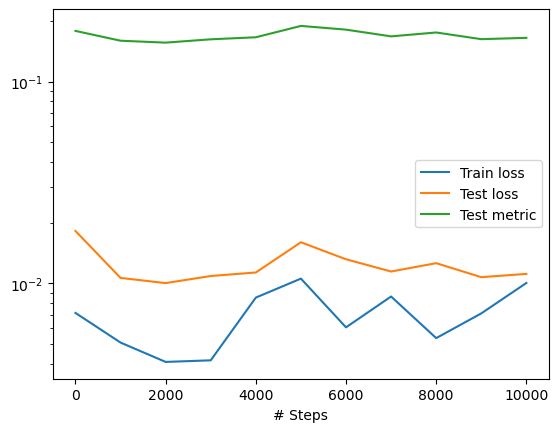

(100, 1000)
3.203135 0.29258427
80
Compiling model...
'compile' took 0.000251 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [8.33e-03]    [1.11e-02]    [1.65e-01]    
1000      [8.65e-03]    [1.19e-02]    [1.67e-01]    
2000      [7.98e-03]    [1.08e-02]    [1.60e-01]    
3000      [1.25e-02]    [1.21e-02]    [1.70e-01]    
4000      [5.28e-03]    [1.15e-02]    [1.65e-01]    
5000      [5.65e-03]    [1.10e-02]    [1.61e-01]    
6000      [8.31e-03]    [1.40e-02]    [1.82e-01]    
7000      [6.75e-03]    [1.25e-02]    [1.73e-01]    
8000      [5.29e-03]    [1.04e-02]    [1.57e-01]    
9000      [5.84e-03]    [9.54e-03]    [1.52e-01]    
10000     [3.16e-03]    [1.03e-02]    [1.59e-01]    

Best model at step 10000:
  train loss: 3.16e-03
  test loss: 1.03e-02
  test metric: [1.59e-01]

'train' took 70.842373 s



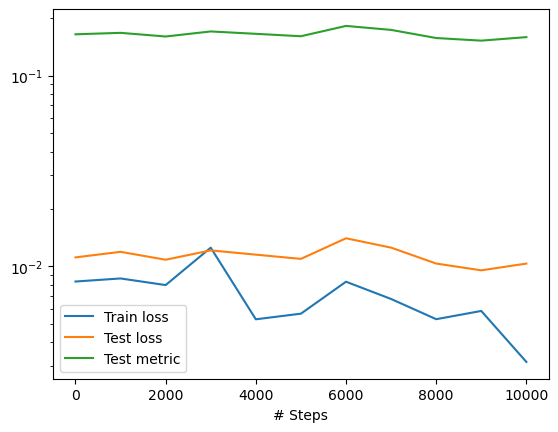

(100, 1000)
3.1848478 0.3513451
100
Compiling model...
'compile' took 0.000374 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [9.01e-03]    [1.03e-02]    [1.59e-01]    
1000      [6.40e-03]    [9.59e-03]    [1.52e-01]    
2000      [4.05e-03]    [1.05e-02]    [1.56e-01]    
3000      [4.56e-03]    [9.67e-03]    [1.53e-01]    
4000      [7.88e-03]    [1.01e-02]    [1.56e-01]    


KeyboardInterrupt: 

In [ ]:
# tune
while len(train_vxs) < total_training_vx:
    # generate some vxs to test
    pde_data = dde.data.TimePDE(geomtime, advection_equation, [], num_domain = 20000)
    eval_pts = np.linspace(0, 1, 101)[:, None] # generate 1000 random vxs
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    func_space = GRF_pos(1.0, length_scale = ls, N= 1000, interp="linear")
    testing_new_data = dde.data.PDEOperatorCartesianProd(pde_data, func_space, eval_pts, check_num, [0])
    # testing_model = dde.Model(testing_new_data, net)
    (vxs, xts), _, c = testing_new_data.train_next_batch()
    out = model.predict((vxs, xts), aux_vars = c, operator = advection_equation)
    
    res = np.mean(np.abs(out), axis = 1)
    print(np.mean(res), np.std(res))
    select_num = min(select_num, total_training_vx - len(train_vxs))
    topk_index = np.argpartition(res, -select_num)[-select_num:] # select the top 20 vxs
    # print(res, topk_index, res[topk_index])
    topk_vxs = vxs[topk_index]
    uxts = parallel_solver(advection_solver, topk_vxs, num_workers = solver_worker)
    uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)
    
    print(len(train_vxs))
    data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])
    
    # tune-train
    model = dde.Model(data, net)
    lr = lr_middle if len(train_vxs) != total_training_vx else lr_end
    decay = decay_middle if len(train_vxs) != total_training_vx else decay_end
    batchsize = batch_middle(len(train_vxs)) if len(train_vxs) != total_training_vx else batch_end(len(train_vxs))
    iterations = iter_middle if len(train_vxs) != total_training_vx else iter_end
    model.compile("adam", 
                  lr = lr, 
                  metrics = ["mean l2 relative error"],
                  decay = decay,)

    losshistory, train_state = model.train(iterations=iterations, batch_size = batchsize)
    
    pd_frame = losshistory.to_pandas()
    pd_frame = pd.concat([pd.read_csv(f"results/adv_{date}_rasg.csv"), pd_frame], axis = 0, ignore_index=True)
    pd_frame.to_csv(f"results/adv_{date}_rasg.csv", index=False)
    dde.utils.plot_loss_history(losshistory)
    plt.show()
    
torch.save(model.state_dict(), f"results/adv_model_{date}_rasg.pth")